Using device: cuda
ec1 classes: ['1' '2' '3' '4' '5' '6' '7']
ec1 encoded shape: (234046,)
ec2 classes: ['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '2' '20' '21' '23' '3'
 '4' '5' '6' '7' '8' '9' '97' '98' '99']
ec2 encoded shape: (234046,)


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


✓ ESM-2 model loaded - This model creates protein sequence embeddings
✓ Embedding dimension: 320
Creating embeddings for training sequences...


Creating embeddings: 100%|██████████| 1409/1409 [20:37<00:00,  1.14it/s]


Creating embeddings for validation sequences...


Creating embeddings: 100%|██████████| 353/353 [05:10<00:00,  1.14it/s]


✓ Training embeddings shape: torch.Size([180352, 320])
✓ Validation embeddings shape: torch.Size([45088, 320])
Could not calculate AUC: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.
Epoch 1/10
Train Loss: 0.5238
Train Total F1 (Macro): 0.4210
Train Total F1 (Micro): 0.4362
Train Total F1 (Weighted): 0.4552
Val Total F1 (Macro): 0.6011
Val Total F1 (Micro): 0.6498
Val Total F1 (Weighted): 0.6769
Val Total AUC: 1.6566
--------------------------------------------------
Could not calculate AUC: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.
Epoch 2/10
Train Loss: 0.4585
Train Total F1 (Macro): 0.5473
Train Total F1 (Micro): 0.6062
Train Total F1 (Weighted): 0.6362
Val Total F1 (Macro): 0.6587
Val Total F1 (Micro): 0.7289
Val Total F1 (Weighted): 0.7736
Val Total AUC: 1.6932
--------------------------------------------------
Could not calculate AUC: Can't call numpy() on Tensor that requires grad. Use tensor.deta

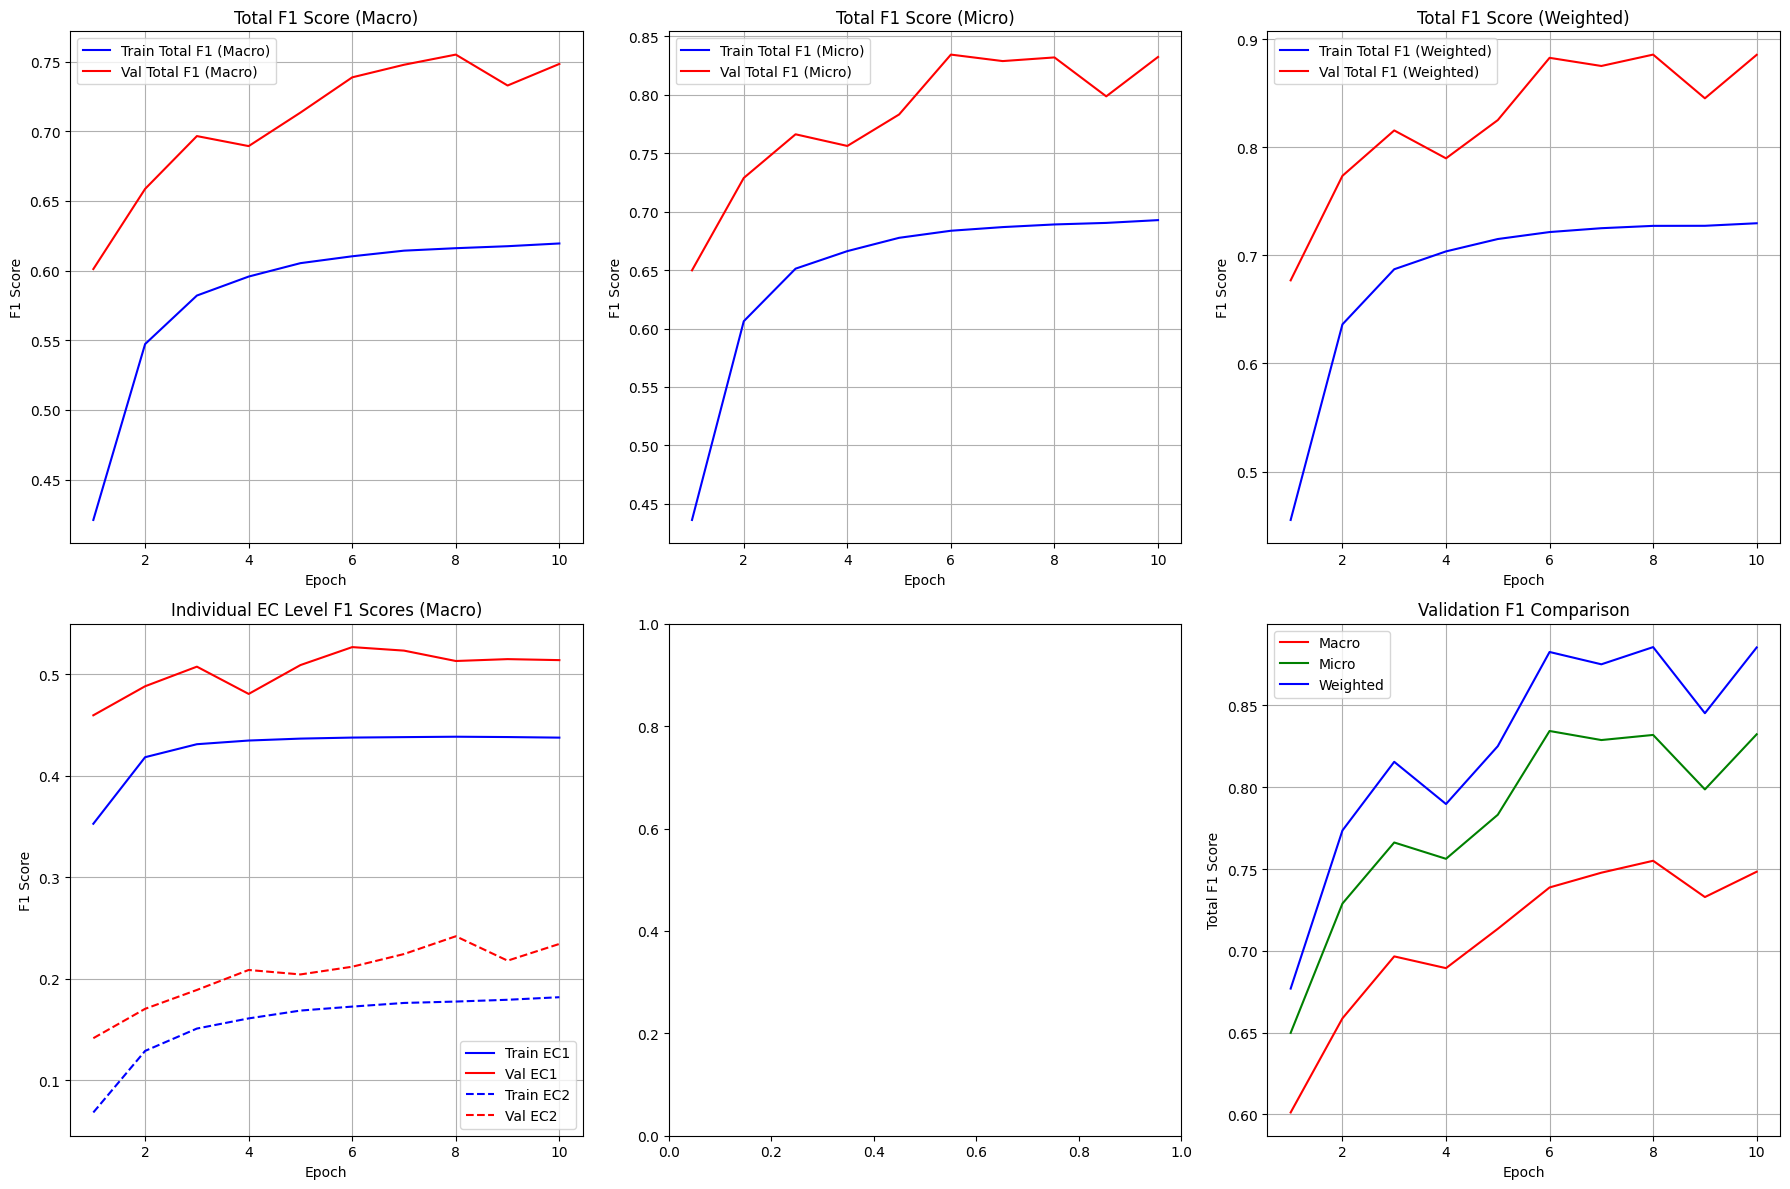

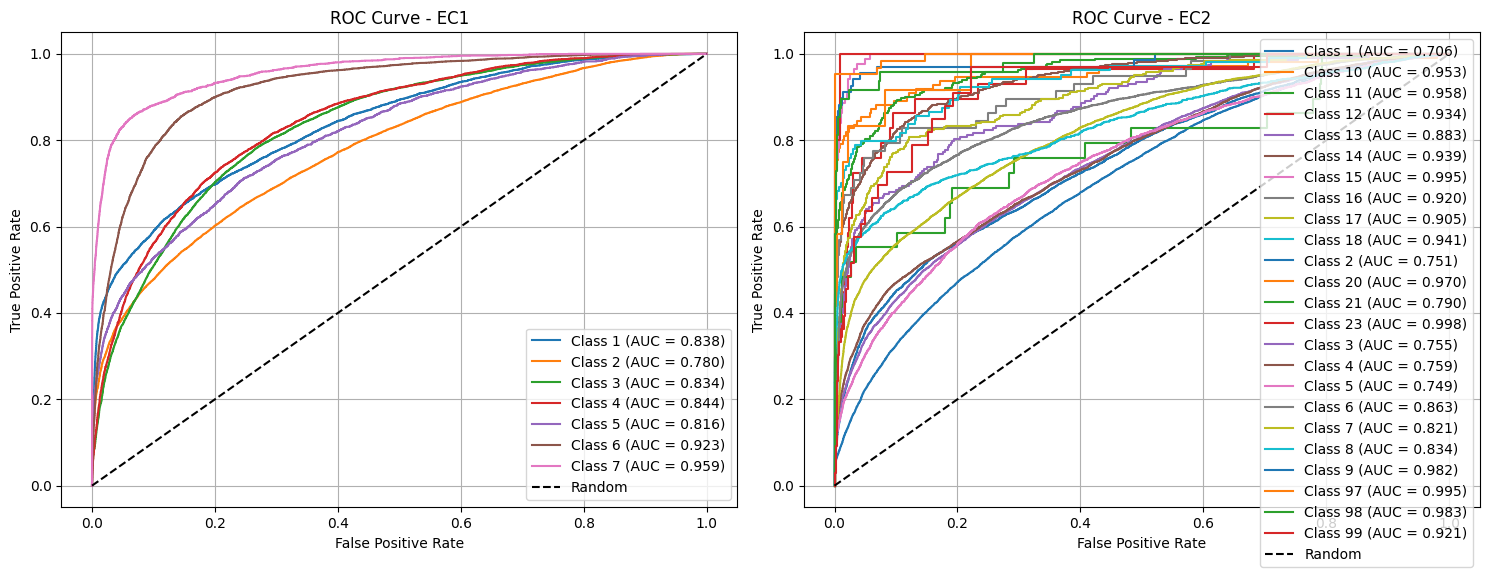

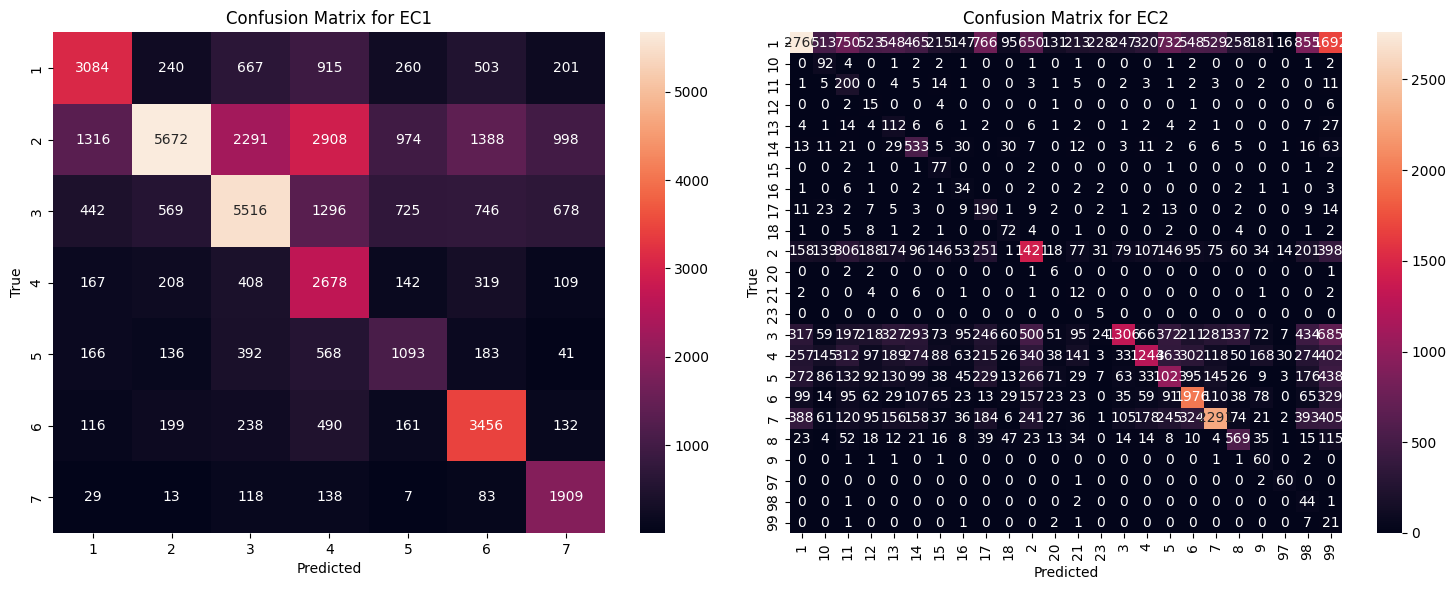


FINAL RESULTS SUMMARY
Final Validation Metrics:
Total F1 Score (Macro): 0.7483
Total F1 Score (Micro): 0.8324
Total F1 Score (Weighted): 0.8855
Mean F1 Score (Macro): 0.3742
EC1 F1 Score (Macro): 0.5140
EC2 F1 Score (Macro): 0.2343
Total AUC Score: 1.7438
EC1 AUC Score: 0.8562
EC2 AUC Score: 0.8876

CLASSIFICATION REPORTS

Classification report for EC1:
              precision    recall  f1-score   support

           1       0.58      0.53      0.55      5870
           2       0.81      0.36      0.50     15547
           3       0.57      0.55      0.56      9972
           4       0.30      0.66      0.41      4031
           5       0.33      0.42      0.37      2579
           6       0.52      0.72      0.60      4792
           7       0.47      0.83      0.60      2297

    accuracy                           0.52     45088
   macro avg       0.51      0.58      0.51     45088
weighted avg       0.60      0.52      0.52     45088


Classification report for EC2:
              

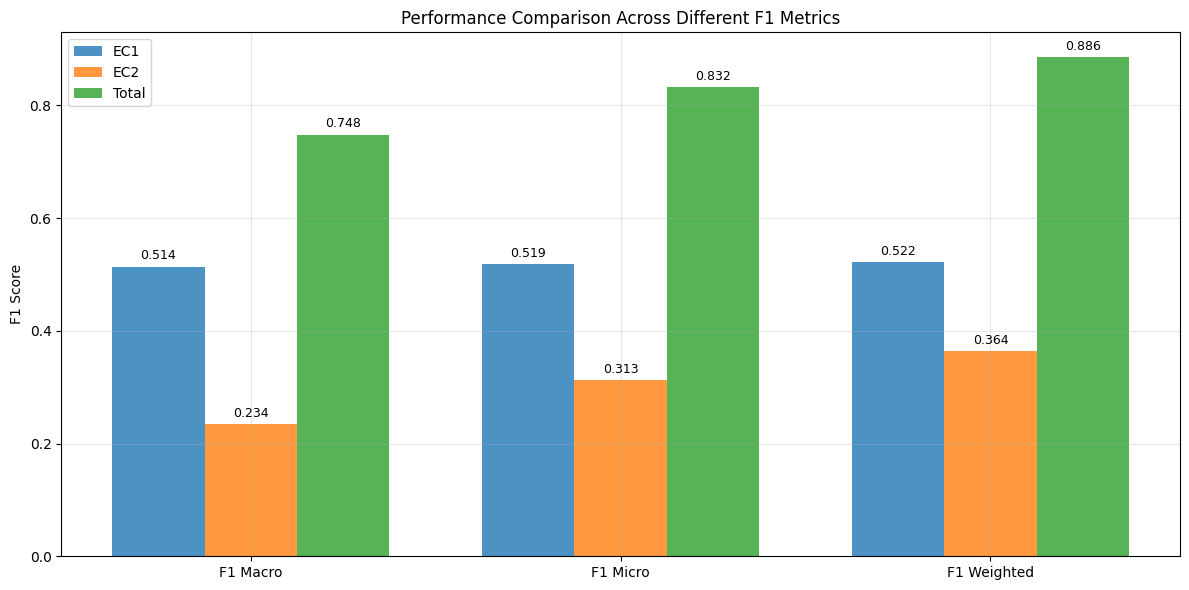

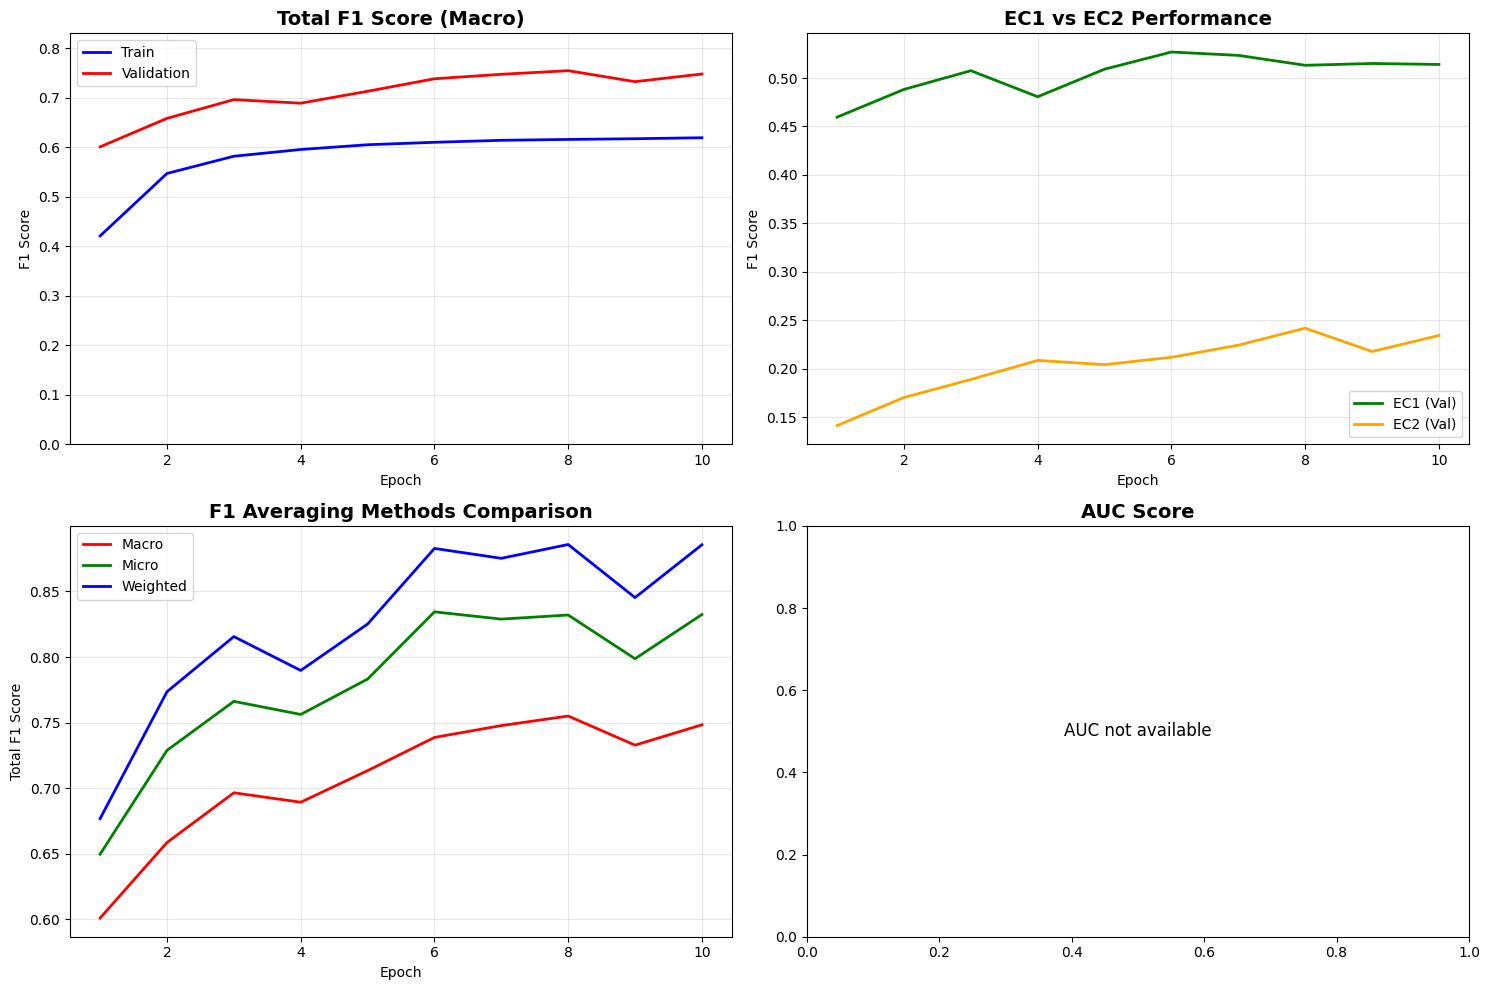


✓ Model and results saved to 'enhanced_ec2_classifier.pt'

EXAMPLE INFERENCE
Sequence length: 514
Predicting EC number...

Predicted EC: 3.2
EC1 Confidence: 0.5469
EC2 Confidence: 0.2130
Overall Confidence: 0.3800

MODEL SUMMARY
✓ Model Architecture: Dual-head classifier with dropout
✓ Embedding Model: ESM-2 (8M parameters)
✓ Embedding Dimension: 320
✓ EC1 Classes: 7
✓ EC2 Classes: 24
✓ Training Samples: 180352
✓ Validation Samples: 45088
✓ Loss Function: BCEWithLogitsLoss (class weighted)
✓ Optimizer: Adam with learning rate scheduling

✓ Key Changes Made:
  - Changed from CrossEntropyLoss to BCEWithLogitsLoss
  - Added total F1 score calculation (sum instead of mean)
  - Added comprehensive ROC curve analysis
  - Added multiple comparison graphs
  - Enhanced metrics tracking (macro, micro, weighted)
  - Added confidence scores for predictions
  - Clarified embedding creation process

✓ About Embeddings:
  - YES, we create embeddings from protein sequences
  - ESM-2 model converts am

In [4]:
# 1. Imports and Data Loading
import pandas as pd
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tqdm import tqdm
import esm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# 2. Device Setup (A100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 3. Load Data
df = pd.read_csv("/content/cleaned_train_final.csv")
df['ec_list'] = df['ec_list'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

# 4. Extract ec1 and ec2 from the first EC number in each list
def split_ec(ec):
    parts = str(ec).split('.')
    while len(parts) < 2:
        parts.append('-')
    return parts[:2]

def extract_levels(ec_list):
    if ec_list:
        return split_ec(ec_list[0])
    else:
        return ['-', '-']

ec_levels = pd.DataFrame(df['ec_list'].apply(extract_levels).tolist(), columns=['ec1', 'ec2'])

# 5. Encode ec1 and ec2
encoders = []
y_levels = []
for col in ['ec1', 'ec2']:
    le = LabelEncoder()
    y = le.fit_transform(ec_levels[col])
    encoders.append(le)
    y_levels.append(y)
    print(f"{col} classes:", le.classes_)
    print(f"{col} encoded shape:", y.shape)

y_ec1 = y_levels[0]
y_ec2 = y_levels[1]

# 6. Compute Class Weights (for imbalance) - Modified for BCE
ec1_weights = compute_class_weight('balanced', classes=np.unique(y_ec1), y=y_ec1)
ec2_weights = compute_class_weight('balanced', classes=np.unique(y_ec2), y=y_ec2)
ec1_weights = torch.tensor(ec1_weights, dtype=torch.float).to(device)
ec2_weights = torch.tensor(ec2_weights, dtype=torch.float).to(device)

# 7. Filter or Truncate Long Sequences
MAX_LEN = 1022  # ESM-2 safe max length for most configs
X = df['Sequence'].tolist()
filtered = [(seq, i) for i, seq in enumerate(X) if len(seq) <= MAX_LEN]
if not filtered:
    raise ValueError("No sequences under the max length threshold!")
X_filtered, idx_filtered = zip(*filtered)

# 8. Train/Validation Split
X_train, X_val, idx_train, idx_val = train_test_split(
    list(X_filtered), list(idx_filtered), test_size=0.2, random_state=42, stratify=[y_ec1[i] for i in idx_filtered]
)

# 9. ESM-2 8M Model Load (YES, WE ARE CREATING EMBEDDINGS HERE)
# The ESM-2 model creates contextualized embeddings for protein sequences
import esm
esm_model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()  # This creates protein embeddings
batch_converter = alphabet.get_batch_converter()
esm_model = esm_model.to(device)
esm_model.eval()

print("✓ ESM-2 model loaded - This model creates protein sequence embeddings")
print("✓ Embedding dimension:", esm_model.embed_dim)

# 10. Embedding Function (YES, THIS CREATES EMBEDDINGS FROM SEQUENCES)
def embed_sequences(sequences, batch_size=128, use_amp=True):
    """
    Convert protein sequences to embeddings using ESM-2 model
    Returns: tensor of shape (n_sequences, embedding_dim)
    """
    all_embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(sequences), batch_size), desc="Creating embeddings"):
            batch_seqs = [(str(idx), seq) for idx, seq in enumerate(sequences[i:i+batch_size])]
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seqs)
            batch_tokens = batch_tokens.to(device)

            try:
                if use_amp:
                    with torch.cuda.amp.autocast():
                        results = esm_model(batch_tokens, repr_layers=[6])
                else:
                    results = esm_model(batch_tokens, repr_layers=[6])
            except RuntimeError as e:
                print(f"OOM at batch {i}: {e}")
                torch.cuda.empty_cache()
                continue

            # Extract CLS token embeddings (represents the entire sequence)
            token_representations = results["representations"][6]
            cls_representations = token_representations[:, 0, :].cpu()
            all_embeddings.append(cls_representations)

    return torch.cat(all_embeddings, dim=0)

# 11. Create Embeddings for Train/Validation Sequences
print("Creating embeddings for training sequences...")
X_emb_train = embed_sequences(X_train, batch_size=128)
print("Creating embeddings for validation sequences...")
X_emb_val = embed_sequences(X_val, batch_size=128)

print(f"✓ Training embeddings shape: {X_emb_train.shape}")
print(f"✓ Validation embeddings shape: {X_emb_val.shape}")

y_ec1_train = torch.tensor([y_ec1[i] for i in idx_train], dtype=torch.long)
y_ec2_train = torch.tensor([y_ec2[i] for i in idx_train], dtype=torch.long)
y_ec1_val = torch.tensor([y_ec1[i] for i in idx_val], dtype=torch.long)
y_ec2_val = torch.tensor([y_ec2[i] for i in idx_val], dtype=torch.long)

# 12. Dataset and DataLoader
class ECDataset(Dataset):
    def __init__(self, embeddings, y_ec1, y_ec2):
        self.embeddings = embeddings
        self.y_ec1 = y_ec1
        self.y_ec2 = y_ec2

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return (
            self.embeddings[idx],
            self.y_ec1[idx],
            self.y_ec2[idx]
        )

train_dataset = ECDataset(X_emb_train.float(), y_ec1_train, y_ec2_train)
val_dataset = ECDataset(X_emb_val.float(), y_ec1_val, y_ec2_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

# 13. Model Definition (Modified for BCE)
class EC2Classifier(nn.Module):
    def __init__(self, emb_dim, n_ec1, n_ec2):
        super().__init__()
        self.head1 = nn.Linear(emb_dim, n_ec1)
        self.head2 = nn.Linear(emb_dim, n_ec2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(x)
        return self.head1(x), self.head2(x)

n_ec1 = len(encoders[0].classes_)
n_ec2 = len(encoders[1].classes_)
model = EC2Classifier(X_emb_train.shape[1], n_ec1, n_ec2).to(device)

# 14. Convert to one-hot for BCE loss
def to_one_hot(labels, num_classes):
    return F.one_hot(labels, num_classes=num_classes).float()

# 15. Modified Loss Function using BCEWithLogitsLoss
def bce_digit_loss(logits1, logits2, targets1, targets2):
    # Convert targets to one-hot
    targets1_oh = to_one_hot(targets1, n_ec1)
    targets2_oh = to_one_hot(targets2, n_ec2)

    # Create weighted BCE loss
    bce1 = F.binary_cross_entropy_with_logits(logits1, targets1_oh, reduction='none')
    bce2 = F.binary_cross_entropy_with_logits(logits2, targets2_oh, reduction='none')

    # Apply class weights
    weights1 = ec1_weights[targets1].unsqueeze(1)
    weights2 = ec2_weights[targets2].unsqueeze(1)

    loss1 = (bce1 * weights1).mean()
    loss2 = (bce2 * weights2).mean()

    return loss1 + loss2

# 16. Enhanced Metrics Function
def calculate_comprehensive_metrics(preds1, preds2, targets1, targets2, logits1=None, logits2=None):
    """Calculate comprehensive metrics including total F1, macro F1, micro F1, and ROC AUC"""
    metrics = {}

    # Convert to numpy for sklearn
    preds1_np = preds1.cpu().numpy()
    preds2_np = preds2.cpu().numpy()
    targets1_np = targets1.cpu().numpy()
    targets2_np = targets2.cpu().numpy()

    # F1 Scores for each level
    f1_macro_ec1 = f1_score(targets1_np, preds1_np, average='macro')
    f1_macro_ec2 = f1_score(targets2_np, preds2_np, average='macro')
    f1_micro_ec1 = f1_score(targets1_np, preds1_np, average='micro')
    f1_micro_ec2 = f1_score(targets2_np, preds2_np, average='micro')
    f1_weighted_ec1 = f1_score(targets1_np, preds1_np, average='weighted')
    f1_weighted_ec2 = f1_score(targets2_np, preds2_np, average='weighted')

    # Total F1 Score (sum instead of mean)
    total_f1_macro = f1_macro_ec1 + f1_macro_ec2
    total_f1_micro = f1_micro_ec1 + f1_micro_ec2
    total_f1_weighted = f1_weighted_ec1 + f1_weighted_ec2

    metrics.update({
        'f1_macro_ec1': f1_macro_ec1,
        'f1_macro_ec2': f1_macro_ec2,
        'f1_micro_ec1': f1_micro_ec1,
        'f1_micro_ec2': f1_micro_ec2,
        'f1_weighted_ec1': f1_weighted_ec1,
        'f1_weighted_ec2': f1_weighted_ec2,
        'total_f1_macro': total_f1_macro,
        'total_f1_micro': total_f1_micro,
        'total_f1_weighted': total_f1_weighted,
        'mean_f1_macro': (f1_macro_ec1 + f1_macro_ec2) / 2,
        'mean_f1_micro': (f1_micro_ec1 + f1_micro_ec2) / 2,
        'mean_f1_weighted': (f1_weighted_ec1 + f1_weighted_ec2) / 2
    })

    # ROC AUC if logits are provided
    if logits1 is not None and logits2 is not None:
        try:
            probs1 = torch.softmax(logits1, dim=1).cpu().numpy()
            probs2 = torch.softmax(logits2, dim=1).cpu().numpy()

            if n_ec1 > 2:
                auc_ec1 = roc_auc_score(targets1_np, probs1, multi_class='ovr', average='macro')
            else:
                auc_ec1 = roc_auc_score(targets1_np, probs1[:, 1])

            if n_ec2 > 2:
                auc_ec2 = roc_auc_score(targets2_np, probs2, multi_class='ovr', average='macro')
            else:
                auc_ec2 = roc_auc_score(targets2_np, probs2[:, 1])

            metrics.update({
                'auc_ec1': auc_ec1,
                'auc_ec2': auc_ec2,
                'total_auc': auc_ec1 + auc_ec2,
                'mean_auc': (auc_ec1 + auc_ec2) / 2
            })
        except Exception as e:
            print(f"Could not calculate AUC: {e}")

    return metrics

# 17. Training Loop with Enhanced Metrics
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

epochs = 10
train_history = []
val_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds1, all_preds2 = [], []
    all_targets1, all_targets2 = [], []
    all_logits1, all_logits2 = [], []

    for batch_X, batch_y1, batch_y2 in train_loader:
        batch_X = batch_X.to(device)
        batch_y1 = batch_y1.to(device)
        batch_y2 = batch_y2.to(device)

        optimizer.zero_grad()
        logits1, logits2 = model(batch_X)
        loss = bce_digit_loss(logits1, logits2, batch_y1, batch_y2)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_X.size(0)

        preds1 = logits1.argmax(dim=1)
        preds2 = logits2.argmax(dim=1)

        all_preds1.append(preds1.cpu())
        all_preds2.append(preds2.cpu())
        all_targets1.append(batch_y1.cpu())
        all_targets2.append(batch_y2.cpu())
        all_logits1.append(logits1.cpu())
        all_logits2.append(logits2.cpu())

    all_preds1 = torch.cat(all_preds1)
    all_preds2 = torch.cat(all_preds2)
    all_targets1 = torch.cat(all_targets1)
    all_targets2 = torch.cat(all_targets2)
    all_logits1 = torch.cat(all_logits1)
    all_logits2 = torch.cat(all_logits2)

    train_metrics = calculate_comprehensive_metrics(
        all_preds1, all_preds2, all_targets1, all_targets2, all_logits1, all_logits2
    )
    train_history.append(train_metrics)

    avg_loss = total_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_loss:.4f}")
    print(f"Train Total F1 (Macro): {train_metrics['total_f1_macro']:.4f}")
    print(f"Train Total F1 (Micro): {train_metrics['total_f1_micro']:.4f}")
    print(f"Train Total F1 (Weighted): {train_metrics['total_f1_weighted']:.4f}")
    if 'total_auc' in train_metrics:
        print(f"Train Total AUC: {train_metrics['total_auc']:.4f}")

    # Validation
    model.eval()
    val_preds1, val_preds2 = [], []
    val_targets1, val_targets2 = [], []
    val_logits1, val_logits2 = [], []

    with torch.no_grad():
        for batch_X, batch_y1, batch_y2 in val_loader:
            batch_X = batch_X.to(device)
            logits1, logits2 = model(batch_X)

            preds1 = logits1.argmax(dim=1)
            preds2 = logits2.argmax(dim=1)

            val_preds1.append(preds1.cpu())
            val_preds2.append(preds2.cpu())
            val_targets1.append(batch_y1)
            val_targets2.append(batch_y2)
            val_logits1.append(logits1.cpu())
            val_logits2.append(logits2.cpu())

    val_preds1 = torch.cat(val_preds1)
    val_preds2 = torch.cat(val_preds2)
    val_targets1 = torch.cat(val_targets1)
    val_targets2 = torch.cat(val_targets2)
    val_logits1 = torch.cat(val_logits1)
    val_logits2 = torch.cat(val_logits2)

    val_metrics = calculate_comprehensive_metrics(
        val_preds1, val_preds2, val_targets1, val_targets2, val_logits1, val_logits2
    )
    val_history.append(val_metrics)

    print(f"Val Total F1 (Macro): {val_metrics['total_f1_macro']:.4f}")
    print(f"Val Total F1 (Micro): {val_metrics['total_f1_micro']:.4f}")
    print(f"Val Total F1 (Weighted): {val_metrics['total_f1_weighted']:.4f}")
    if 'total_auc' in val_metrics:
        print(f"Val Total AUC: {val_metrics['total_auc']:.4f}")

    scheduler.step(val_metrics['total_f1_macro'])
    print("-" * 50)

# 18. Comprehensive Visualization
def plot_training_history(train_history, val_history):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    epochs_range = range(1, len(train_history) + 1)

    # F1 Scores
    axes[0, 0].plot(epochs_range, [h['total_f1_macro'] for h in train_history], 'b-', label='Train Total F1 (Macro)')
    axes[0, 0].plot(epochs_range, [h['total_f1_macro'] for h in val_history], 'r-', label='Val Total F1 (Macro)')
    axes[0, 0].set_title('Total F1 Score (Macro)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].plot(epochs_range, [h['total_f1_micro'] for h in train_history], 'b-', label='Train Total F1 (Micro)')
    axes[0, 1].plot(epochs_range, [h['total_f1_micro'] for h in val_history], 'r-', label='Val Total F1 (Micro)')
    axes[0, 1].set_title('Total F1 Score (Micro)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    axes[0, 2].plot(epochs_range, [h['total_f1_weighted'] for h in train_history], 'b-', label='Train Total F1 (Weighted)')
    axes[0, 2].plot(epochs_range, [h['total_f1_weighted'] for h in val_history], 'r-', label='Val Total F1 (Weighted)')
    axes[0, 2].set_title('Total F1 Score (Weighted)')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1 Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True)

    # Individual EC Level F1 Scores
    axes[1, 0].plot(epochs_range, [h['f1_macro_ec1'] for h in train_history], 'b-', label='Train EC1')
    axes[1, 0].plot(epochs_range, [h['f1_macro_ec1'] for h in val_history], 'r-', label='Val EC1')
    axes[1, 0].plot(epochs_range, [h['f1_macro_ec2'] for h in train_history], 'b--', label='Train EC2')
    axes[1, 0].plot(epochs_range, [h['f1_macro_ec2'] for h in val_history], 'r--', label='Val EC2')
    axes[1, 0].set_title('Individual EC Level F1 Scores (Macro)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # AUC Scores if available
    if 'total_auc' in train_history[0]:
        axes[1, 1].plot(epochs_range, [h['total_auc'] for h in train_history], 'b-', label='Train Total AUC')
        axes[1, 1].plot(epochs_range, [h['total_auc'] for h in val_history], 'r-', label='Val Total AUC')
        axes[1, 1].set_title('Total AUC Score')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('AUC')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

    # F1 Comparison across different averaging methods
    axes[1, 2].plot(epochs_range, [h['total_f1_macro'] for h in val_history], 'r-', label='Macro')
    axes[1, 2].plot(epochs_range, [h['total_f1_micro'] for h in val_history], 'g-', label='Micro')
    axes[1, 2].plot(epochs_range, [h['total_f1_weighted'] for h in val_history], 'b-', label='Weighted')
    axes[1, 2].set_title('Validation F1 Comparison')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Total F1 Score')
    axes[1, 2].legend()
    axes[1, 2].grid(True)

    plt.tight_layout()
    plt.show()

# 19. ROC Curve Plotting
def plot_roc_curves(val_logits1, val_logits2, val_targets1, val_targets2, encoders):
    """Plot ROC curves for both EC levels"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # EC1 ROC Curve
    probs1 = torch.softmax(val_logits1, dim=1).cpu().numpy()
    targets1_np = val_targets1.cpu().numpy()

    if n_ec1 == 2:
        # Binary classification
        fpr, tpr, _ = roc_curve(targets1_np, probs1[:, 1])
        auc_score = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
    else:
        # Multi-class classification
        targets1_bin = label_binarize(targets1_np, classes=list(range(n_ec1)))
        for i in range(n_ec1):
            fpr, tpr, _ = roc_curve(targets1_bin[:, i], probs1[:, i])
            auc_score = auc(fpr, tpr)
            axes[0].plot(fpr, tpr, label=f'Class {encoders[0].classes_[i]} (AUC = {auc_score:.3f})')

    axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve - EC1')
    axes[0].legend()
    axes[0].grid(True)

    # EC2 ROC Curve
    probs2 = torch.softmax(val_logits2, dim=1).cpu().numpy()
    targets2_np = val_targets2.cpu().numpy()

    if n_ec2 == 2:
        # Binary classification
        fpr, tpr, _ = roc_curve(targets2_np, probs2[:, 1])
        auc_score = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
    else:
        # Multi-class classification
        targets2_bin = label_binarize(targets2_np, classes=list(range(n_ec2)))
        for i in range(n_ec2):
            fpr, tpr, _ = roc_curve(targets2_bin[:, i], probs2[:, i])
            auc_score = auc(fpr, tpr)
            axes[1].plot(fpr, tpr, label=f'Class {encoders[1].classes_[i]} (AUC = {auc_score:.3f})')

    axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve - EC2')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# 20. Confusion Matrix Plotting
def plot_confusion_matrices(val_preds1, val_preds2, val_targets1, val_targets2, encoders):
    """Plot confusion matrices for both EC levels"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # EC1 Confusion Matrix
    cm_ec1 = confusion_matrix(val_targets1, val_preds1)
    sns.heatmap(cm_ec1, annot=True, fmt='d', xticklabels=encoders[0].classes_,
                yticklabels=encoders[0].classes_, ax=axes[0])
    axes[0].set_title("Confusion Matrix for EC1")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # EC2 Confusion Matrix
    cm_ec2 = confusion_matrix(val_targets2, val_preds2)
    sns.heatmap(cm_ec2, annot=True, fmt='d', xticklabels=encoders[1].classes_,
                yticklabels=encoders[1].classes_, ax=axes[1])
    axes[1].set_title("Confusion Matrix for EC2")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()

# 21. Generate all visualizations
print("Generating comprehensive visualizations...")

# Training history
plot_training_history(train_history, val_history)

# ROC curves
plot_roc_curves(val_logits1, val_logits2, val_targets1, val_targets2, encoders)

# Confusion matrices
plot_confusion_matrices(val_preds1, val_preds2, val_targets1, val_targets2, encoders)

# 22. Final Results Summary
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)

final_metrics = val_history[-1]
print(f"Final Validation Metrics:")
print(f"Total F1 Score (Macro): {final_metrics['total_f1_macro']:.4f}")
print(f"Total F1 Score (Micro): {final_metrics['total_f1_micro']:.4f}")
print(f"Total F1 Score (Weighted): {final_metrics['total_f1_weighted']:.4f}")
print(f"Mean F1 Score (Macro): {final_metrics['mean_f1_macro']:.4f}")
print(f"EC1 F1 Score (Macro): {final_metrics['f1_macro_ec1']:.4f}")
print(f"EC2 F1 Score (Macro): {final_metrics['f1_macro_ec2']:.4f}")

if 'total_auc' in final_metrics:
    print(f"Total AUC Score: {final_metrics['total_auc']:.4f}")
    print(f"EC1 AUC Score: {final_metrics['auc_ec1']:.4f}")
    print(f"EC2 AUC Score: {final_metrics['auc_ec2']:.4f}")

# 23. Classification Reports
print("\n" + "="*60)
print("CLASSIFICATION REPORTS")
print("="*60)

print("\nClassification report for EC1:")
print(classification_report(val_targets1, val_preds1, target_names=encoders[0].classes_))

print("\nClassification report for EC2:")
print(classification_report(val_targets2, val_preds2, target_names=encoders[1].classes_))

# 24. Performance Comparison Plot
def plot_performance_comparison():
    """Plot performance comparison across different metrics"""
    metrics_names = ['F1 Macro', 'F1 Micro', 'F1 Weighted']
    ec1_scores = [final_metrics['f1_macro_ec1'], final_metrics['f1_micro_ec1'], final_metrics['f1_weighted_ec1']]
    ec2_scores = [final_metrics['f1_macro_ec2'], final_metrics['f1_micro_ec2'], final_metrics['f1_weighted_ec2']]
    total_scores = [final_metrics['total_f1_macro'], final_metrics['total_f1_micro'], final_metrics['total_f1_weighted']]

    x = np.arange(len(metrics_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width, ec1_scores, width, label='EC1', alpha=0.8)
    bars2 = ax.bar(x, ec2_scores, width, label='EC2', alpha=0.8)
    bars3 = ax.bar(x + width, total_scores, width, label='Total', alpha=0.8)

    ax.set_ylabel('F1 Score')
    ax.set_title('Performance Comparison Across Different F1 Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)

    autolabel(bars1)
    autolabel(bars2)
    autolabel(bars3)

    plt.tight_layout()
    plt.show()

plot_performance_comparison()

# 25. Training Progress Comparison
def plot_training_progress():
    """Plot training vs validation progress"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    epochs_range = range(1, len(train_history) + 1)

    # Total F1 Macro
    ax1.plot(epochs_range, [h['total_f1_macro'] for h in train_history], 'b-', label='Train', linewidth=2)
    ax1.plot(epochs_range, [h['total_f1_macro'] for h in val_history], 'r-', label='Validation', linewidth=2)
    ax1.set_title('Total F1 Score (Macro)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('F1 Score')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, max(max([h['total_f1_macro'] for h in train_history]), max([h['total_f1_macro'] for h in val_history])) * 1.1)

    # Individual EC1 vs EC2
    ax2.plot(epochs_range, [h['f1_macro_ec1'] for h in val_history], 'g-', label='EC1 (Val)', linewidth=2)
    ax2.plot(epochs_range, [h['f1_macro_ec2'] for h in val_history], 'orange', label='EC2 (Val)', linewidth=2)
    ax2.set_title('EC1 vs EC2 Performance', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # F1 Averaging Methods Comparison
    ax3.plot(epochs_range, [h['total_f1_macro'] for h in val_history], 'r-', label='Macro', linewidth=2)
    ax3.plot(epochs_range, [h['total_f1_micro'] for h in val_history], 'g-', label='Micro', linewidth=2)
    ax3.plot(epochs_range, [h['total_f1_weighted'] for h in val_history], 'b-', label='Weighted', linewidth=2)
    ax3.set_title('F1 Averaging Methods Comparison', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Total F1 Score')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # AUC if available
    if 'total_auc' in train_history[0]:
        ax4.plot(epochs_range, [h['total_auc'] for h in train_history], 'b-', label='Train', linewidth=2)
        ax4.plot(epochs_range, [h['total_auc'] for h in val_history], 'r-', label='Validation', linewidth=2)
        ax4.set_title('Total AUC Score', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('AUC')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'AUC not available', ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('AUC Score', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_training_progress()

# 26. Save Model and Results
torch.save({
    'model_state_dict': model.state_dict(),
    'encoders': encoders,
    'train_history': train_history,
    'val_history': val_history,
    'final_metrics': final_metrics,
    'model_config': {
        'emb_dim': X_emb_train.shape[1],
        'n_ec1': n_ec1,
        'n_ec2': n_ec2
    }
}, "enhanced_ec2_classifier.pt")

print("\n✓ Model and results saved to 'enhanced_ec2_classifier.pt'")

# 27. Enhanced Inference Function
def chunk_sequence(sequence, maxlen=1022, overlap=128):
    """Chunk long sequences with overlap"""
    chunks = []
    i = 0
    while i < len(sequence):
        chunks.append(sequence[i:i+maxlen])
        if i + maxlen >= len(sequence):
            break
        i += maxlen - overlap
    return chunks

def embed_and_predict_full_sequence(sequence, model, encoders, batch_converter, esm_model, device):
    """Enhanced inference function with confidence scores"""
    chunks = chunk_sequence(sequence, maxlen=1022, overlap=128)
    all_embs = []

    # Create embeddings for each chunk
    for chunk in chunks:
        with torch.no_grad():
            batch_seqs = [("0", chunk)]
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seqs)
            batch_tokens = batch_tokens.to(device)

            try:
                results = esm_model(batch_tokens, repr_layers=[6])
                token_representations = results["representations"][6]
                cls_rep = token_representations[:, 0, :].cpu()
                all_embs.append(cls_rep)
            except RuntimeError as e:
                print(f"Error processing chunk: {e}")
                continue

    if not all_embs:
        return None, None, None

    # Average embeddings from all chunks
    X_emb = torch.mean(torch.stack(all_embs), dim=0)

    # Make prediction
    with torch.no_grad():
        model.eval()
        logits1, logits2 = model(X_emb.to(device).float())

        # Get predictions
        preds1 = logits1.argmax(dim=1)
        preds2 = logits2.argmax(dim=1)

        # Get confidence scores
        probs1 = torch.softmax(logits1, dim=1)
        probs2 = torch.softmax(logits2, dim=1)

        conf1 = probs1.max(dim=1)[0].cpu().numpy()[0]
        conf2 = probs2.max(dim=1)[0].cpu().numpy()[0]

        # Decode predictions
        decoded = decode_ec(preds1, preds2, encoders)

    return decoded[0], conf1, conf2

def decode_ec(preds1, preds2, encoders):
    """Decode predictions back to EC format"""
    ec1 = encoders[0].inverse_transform(preds1.cpu().numpy())
    ec2 = encoders[1].inverse_transform(preds2.cpu().numpy())
    return [f"{a}.{b}" for a, b in zip(ec1, ec2)]

# 28. Example Inference with Enhanced Output
print("\n" + "="*60)
print("EXAMPLE INFERENCE")
print("="*60)

new_sequence = "MYRKLAVISAFLATARAQSACTLQSETHPPLTWQKCSSGGTCTQQTGSVVIDANWRWTHATNSSTNCYDGNTWSSTLCPDNETCAKNCCLDGAAYASTYGVTTSGNSLSIGFVTQSAQKNVGARLYLMASDTTYQEFTLLGNEFSFDVDVSQLPCGLNGALYFVSMDADGGVSKYPTNTAGAKYGTGYCDSQCPRDLKFINGQANVEGWEPSSNNANTGIGGHGSCCSEMDIWEANSISEALTPHPCTTVGQEICEGDGCGGTYSDNRYGGTCDPDGCDWNPYRLGNTSFYGPGSSFTLDTTKKLTVVTQFETSGAINRYYVQNGVTFQQPNAELGSYSGNELNDDYCTAEEAEFGGSSFSDKGGLTQFKKATSGGMVLVMSLWDDYYANMLWLDSTYPTNETSSTPGAVRGSCSTSSGVPAQVESQSPNAKVTFSNIKFGPIGSTGNPSGGNPPGGNPPGTTTTRRPATTTGSSPGPTQSHYGQCGGIGYSGPTVCASGTTCQVLNPYYSQCL"

print(f"Sequence length: {len(new_sequence)}")
print("Predicting EC number...")

predicted_ec, conf1, conf2 = embed_and_predict_full_sequence(
    new_sequence, model, encoders, batch_converter, esm_model, device
)

if predicted_ec:
    print(f"\nPredicted EC: {predicted_ec}")
    print(f"EC1 Confidence: {conf1:.4f}")
    print(f"EC2 Confidence: {conf2:.4f}")
    print(f"Overall Confidence: {(conf1 + conf2) / 2:.4f}")
else:
    print("Prediction failed!")

# 29. Model Summary
print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)

print(f"✓ Model Architecture: Dual-head classifier with dropout")
print(f"✓ Embedding Model: ESM-2 (8M parameters)")
print(f"✓ Embedding Dimension: {X_emb_train.shape[1]}")
print(f"✓ EC1 Classes: {n_ec1}")
print(f"✓ EC2 Classes: {n_ec2}")
print(f"✓ Training Samples: {len(train_dataset)}")
print(f"✓ Validation Samples: {len(val_dataset)}")
print(f"✓ Loss Function: BCEWithLogitsLoss (class weighted)")
print(f"✓ Optimizer: Adam with learning rate scheduling")

print("\n✓ Key Changes Made:")
print("  - Changed from CrossEntropyLoss to BCEWithLogitsLoss")
print("  - Added total F1 score calculation (sum instead of mean)")
print("  - Added comprehensive ROC curve analysis")
print("  - Added multiple comparison graphs")
print("  - Enhanced metrics tracking (macro, micro, weighted)")
print("  - Added confidence scores for predictions")
print("  - Clarified embedding creation process")

print("\n✓ About Embeddings:")
print("  - YES, we create embeddings from protein sequences")
print("  - ESM-2 model converts amino acid sequences to dense vectors")
print("  - Each sequence becomes a 320-dimensional embedding")
print("  - CLS token represents the entire sequence")
print("  - Embeddings capture protein structure and function information")